In [1]:
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

In [3]:
df = pd.read_csv(csv_file)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [5]:
target = df.pop('target')

In [6]:
'''
Can just work with DataFrames at all times if they are all the same data types as it supports __array__ which means it can be 
converted to a tensor to be worked with

Generally, if an object can be converted to a tensor, it can be passed anywhere you can pass a tf.tensor
'''

numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


In [7]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]])>

In [8]:
# Z-score standardization?
# should always allow the normalization layer to adapt to get the mean and standard deviation

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

In [9]:
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.26008666,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573878 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.3368772 ,  1.3259765 ]],
      dtype=float32)>

In [10]:
'''
utillize the layer with normalization 

adapt the normalization layers with all the training data before using it, the values will not be changed when .fit() is called
'''

def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [11]:
model = get_basic_model()
model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
152/152 [==============================] - 2s 3ms/step - loss: 0.7516 - accuracy: 0.6370
Epoch 2/15
152/152 [==============================] - 1s 3ms/step - loss: 0.5874 - accuracy: 0.7228
Epoch 3/15
152/152 [==============================] - 0s 3ms/step - loss: 0.5225 - accuracy: 0.7393
Epoch 4/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4870 - accuracy: 0.7492
Epoch 5/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.7657
Epoch 6/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4519 - accuracy: 0.7657
Epoch 7/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.7756
Epoch 8/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4396 - accuracy: 0.7756
Epoch 9/15
152/152 [==============================] - 1s 4ms/step - loss: 0.4343 - accuracy: 0.7855
Epoch 10/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4321 - accuracy: 0.7855

In [12]:
'''
Doing encoding for mixed datasets, where there are categorical and numerical features
'''

binary_feature_names = ['sex', 'fbs', 'exang']
categorical_feature_names = ['cp', 'restecg', 'slope', 'thal', 'ca']

In [13]:
# Getting all the feature names

inputs = {}
for name, column in df.items():
    
    # if it is a string
    if type(column[0]) == str:
        dtype = tf.string
    # if it is a categorical or binary feature
    elif (name in categorical_feature_names or
            name in binary_feature_names):
        dtype = tf.int64
    # if it is a numerical feature
    else:
        dtype = tf.float32

    # build the input layer dictionary, without the values (tensorflow will look for an input data dictionary since we use a dict to preprocess our inputs)
    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)
    
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [14]:
preprocessed = []

for name in binary_feature_names:
  inp = inputs[name]
  # expanding the dimensions to accomodate data from n data points => create a dimension to take in inputs
  inp = inp[:, tf.newaxis]
  
  # cast the input into a float, no idea why we dont cast from the start => becaues the input data type is int64 
  
  # the layer will know that it will take in int64 data and cast it to a float32 data
  float_value = tf.cast(inp, tf.float32)
  preprocessed.append(float_value)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>]

In [15]:
# working with all the data for numeric values

def stack_dict(inputs, fun=tf.stack):
    values = []
    
    # cast all the inputs into float32
    for key in sorted(inputs.keys()):
      # dont really have to cast the inputs since its already float32
      values.append(tf.cast(inputs[key], tf.float32))
      # values.append(inputs[key])

    # stack in the last dimension
    return fun(values, axis=-1)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

# adapt n columns of mean and standard deviations

In [16]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name] = inputs[name]

# stacking the tensors by expanding the dimensions by 1, not the actual values => will have 5 tensors (possible to just stack all of them 1 by 1)
numeric_inputs = stack_dict(numeric_inputs)

# each tensor will be normalized with the normalizer
# the shape is (None, 5) => None is the batch, 5 is the number of dimensions, can think of this as the number of features
numeric_normalized = normalizer(numeric_inputs)

# the numeric inputs will know that it needs to be stacked, and be normalized through the normalizer layer
preprocessed.append(numeric_normalized)

# preprocessed
numeric_inputs

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'tf.stack')>

In [17]:
# example of how one-hot-encoding for strings work

vocab = ['a','b','c']
lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
lookup(['c','a','a','b','zzz'])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [18]:
# example of how one-hot-encoding for integers work

vocab = [1,4,7,99]
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

lookup([-1,4,1])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [19]:
for name in categorical_feature_names:
    # set will remove all duplicates, and we want the values sorted in order
    vocab = sorted(set(df[name]))
    print(f'name: {name}')
    print(f'vocab: {vocab}\n')

    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

    x = inputs[name][:, tf.newaxis]
    x = lookup(x)
    preprocessed.append(x)
    
# each layer will undergo its own StringLookup/ IntegerLookup => each input will have its own predefined OHE
# thus, when testing, dont have to worry too much

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']

name: ca
vocab: [0, 1, 2, 3]



In [20]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_4')>]

In [21]:
preprocesssed_result = tf.concat(preprocessed, axis=1)
preprocesssed_result

# afterwards, concat all the tensors such that they are columns side by side

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat')>

In [22]:
# inputs=inputs, outputs=preprocessed_result,
'''
This works and builds a preprocessing model as it works from input layers

From the start,

1. We build the input layers for each feature using tf.keras.Input(shape=(), name=name, dtype=dtype)
- when building the input layers, input_shape = (), to specify only keeping track of batches

2. We do intermediate steps with all the input layers => keras keeps track of it
- for binary inputs, expand dimensions
- for numeric inputs, just do normalization and dimensions will expand accordingly

3. When we pass in the inputs and outputs, it builds the preprocessing pipeline (read the commented stuff above for an in-depth explanation)

4. For testing, make the test data into dictionaries as well
'''
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

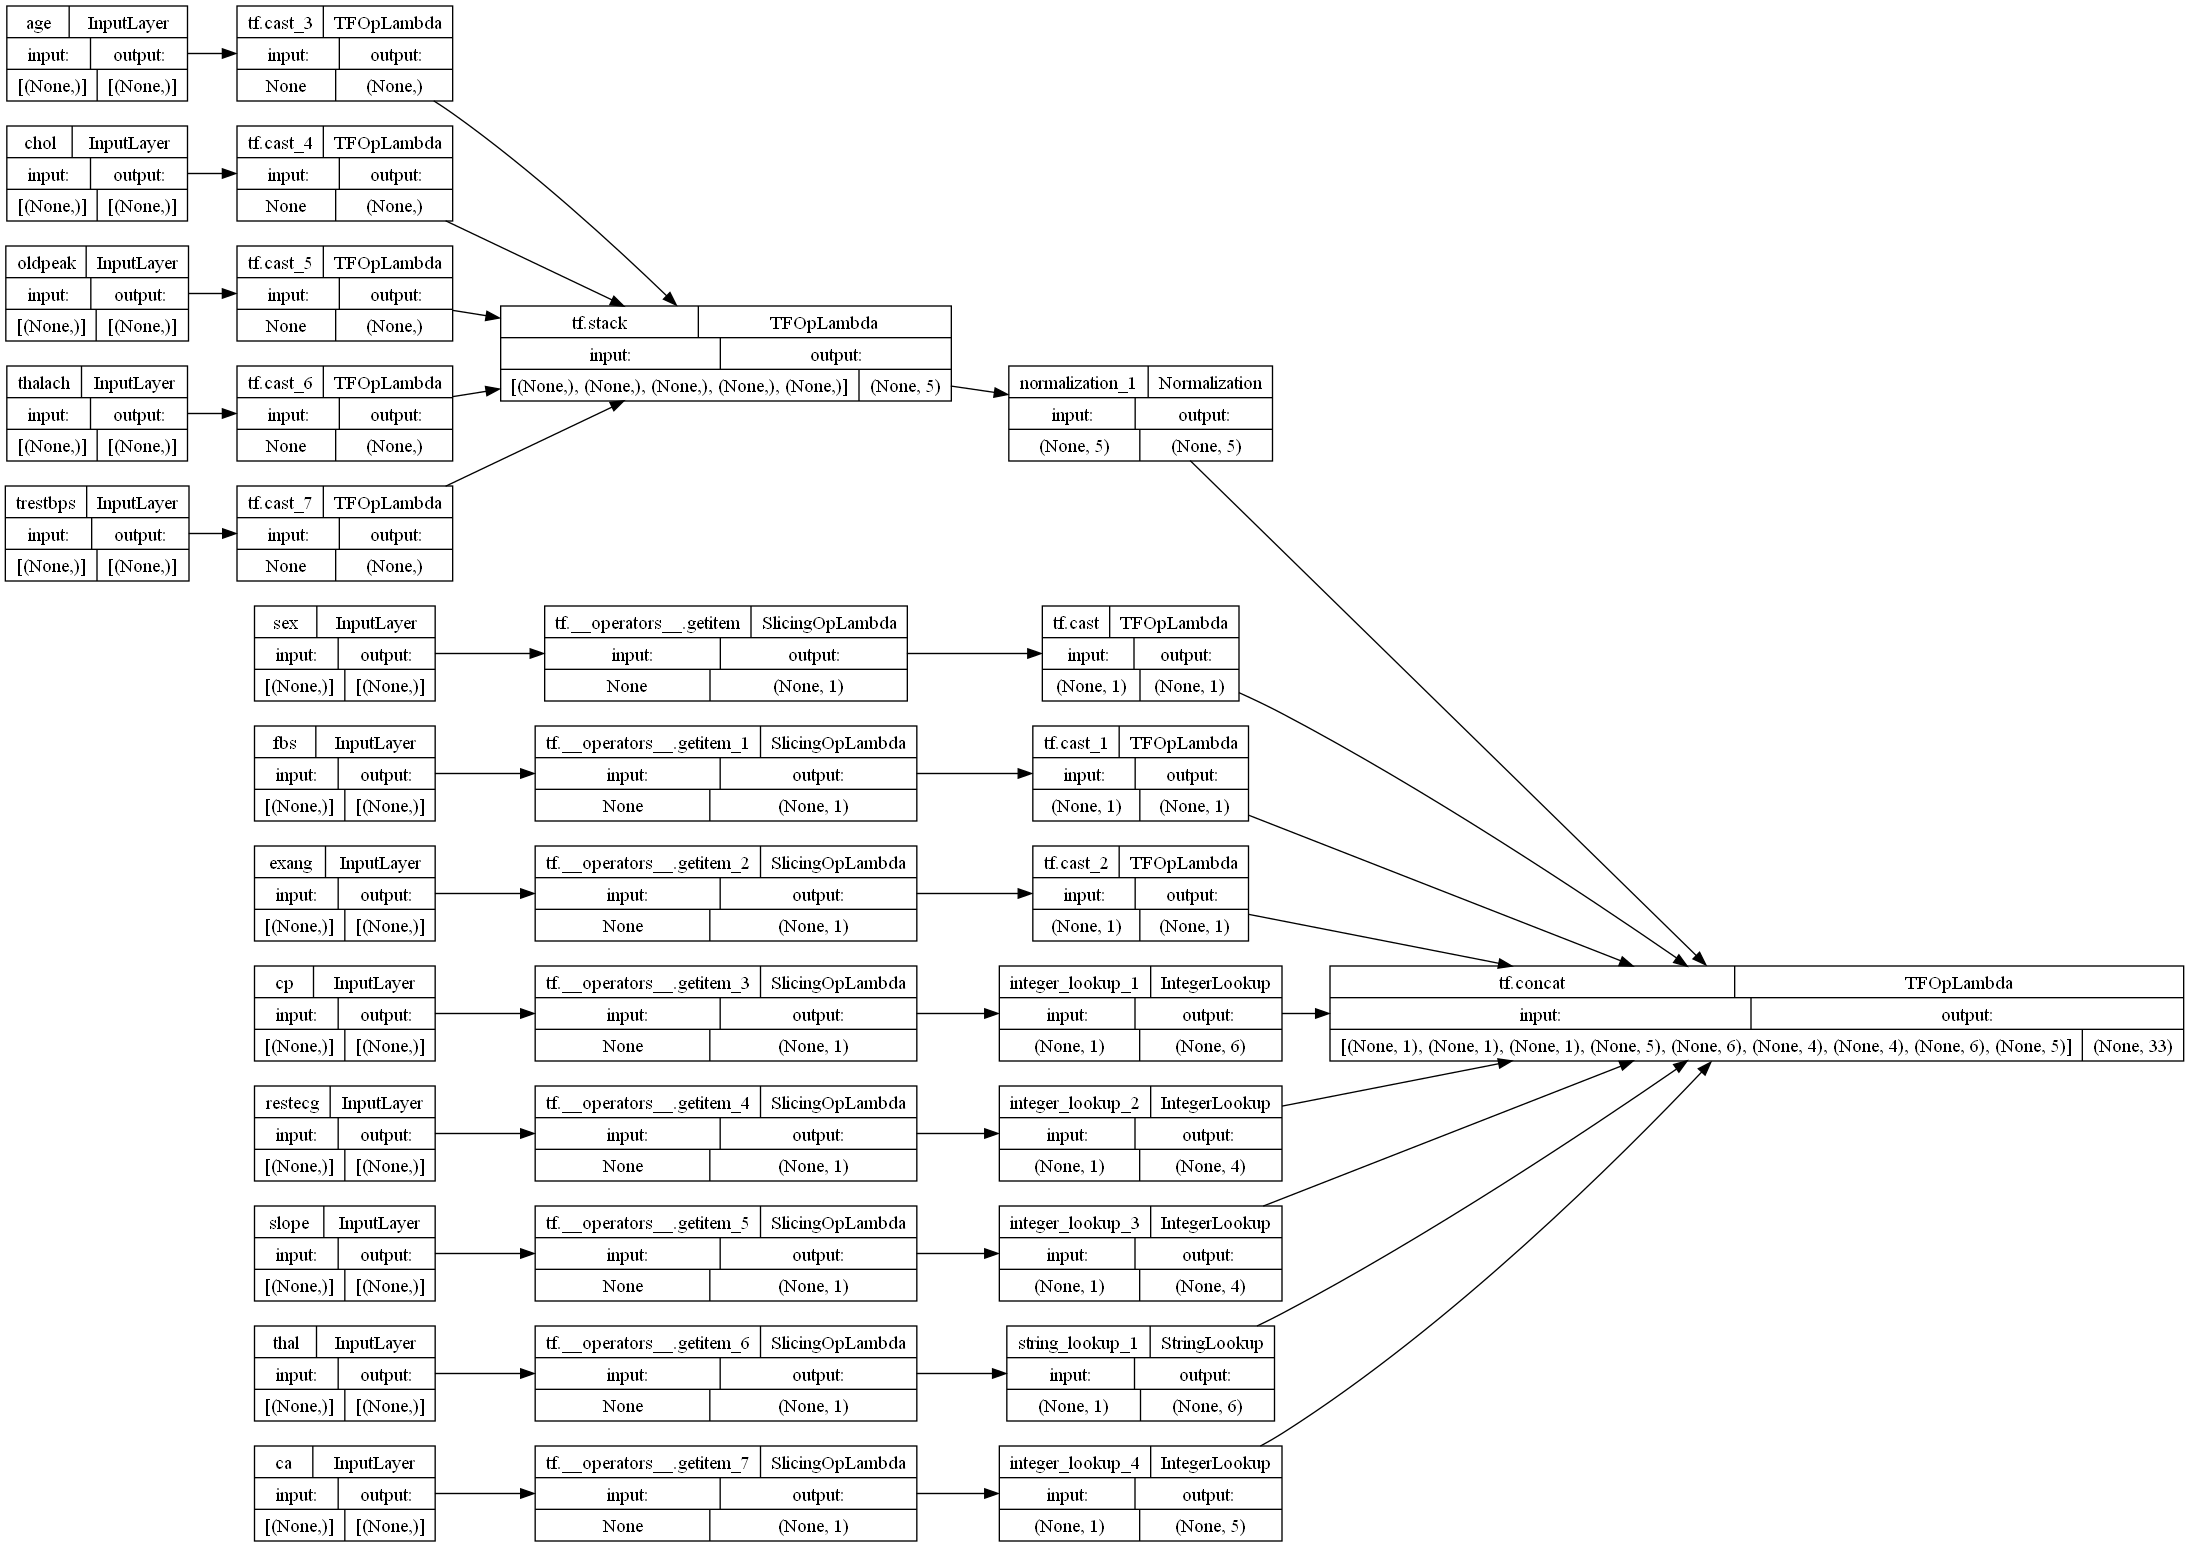

In [23]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [24]:
# preprocessor(dict(df.iloc[:1]))

In [25]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [26]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [27]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model')>

In [28]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_1')>

In [29]:
df['age1'] = df['age']
df.columns
# df = df.drop('age', axis=1)

# if inputs do not have the required inputs during training, will throw an error, if its unknown, will just be ignored

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'age1'],
      dtype='object')

In [30]:
history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


ValueError: in user code:

    File "c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "normalization_input". You passed a data dictionary with keys ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'age1']. Expected the following keys: ['normalization_input']
